In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
import time
from datetime import timedelta
import os

%matplotlib inline

In [3]:
df = pd.read_csv(r"C:\Users\rg654th\Downloads\Flight Delay\Clean Data\Clean Historical Data.csv", parse_dates=[0], infer_datetime_format=True)

In [4]:
# New Column and Format
df['Scheduled DateTime'] = pd.to_datetime(df['Scheduled DateTime'], infer_datetime_format=True)
df['Delay? (15 min)'] = np.where(df['Minute Delay'] >= 20, 'Yes', 'No')

In [5]:
# df['Sched_mins_since_midnight']
df['Sched_mins_since_midnight'] = (df['Scheduled DateTime'] - df['Scheduled DateTime'].apply(lambda dt: dt.replace(hour=0, minute=0, second=0, microsecond=0)))
df['Sched_mins_since_midnight'] = df['Sched_mins_since_midnight'] / np.timedelta64(1, 'm')

In [6]:
traindf = df.drop(['Flight No.', 'Scheduled Date','Scheduled DateTime', 'Scheduled Time', 'Real Departure Time'], axis=1)
traindf = traindf.dropna()
traindf.shape

(4849, 9)

In [7]:
newtraindf = pd.get_dummies(traindf)
newtraindf.head(1)

,Minute Delay,Sched_mins_since_midnight,Terminal_T1,Terminal_T2,Destination_Aberdeen,Destination_Abu Dhabi,Destination_Agadir,Destination_Alicante,Destination_Almeria,Destination_Amsterdam,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Delay Type_Long,Delay Type_Medium,Delay Type_None,Delay Type_Short,Delay? (15 min)_No,Delay? (15 min)_Yes
0,14,1110.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [8]:
# Split Data
x_data = newtraindf.drop(['Minute Delay', 'Delay Type_None', 'Delay Type_Short', 'Delay Type_Long', 'Delay Type_Medium', 'Delay? (15 min)_No', 'Delay? (15 min)_Yes'],axis=1)
y_data = newtraindf['Delay? (15 min)_Yes']
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.25)

In [9]:
# Ensemble 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 

C:\Users\rg654th\AppData\Local\Continuum\anaconda3\envs\tfdeeplearning\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
model = AdaBoostClassifier()
model.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [21]:
y_pred = model.predict(x_test)

score2 = metrics.accuracy_score(y_test, y_pred)
score3 = metrics.precision_score(y_test, y_pred)
score4 = metrics.recall_score(y_test, y_pred)

print("Precision", "", score3)
print("Accuracy", "", score2)
print("Recall", "", score4)

Precision  0.6302083333333334
Accuracy  0.6661170651277823
Recall  0.4792079207920792


In [12]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=0.000001)
model2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1e-06,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
y_pred2 = model2.predict(x_test)

score2 = metrics.accuracy_score(y_test, y_pred2)
score3 = metrics.precision_score(y_test, y_pred2)
score4 = metrics.recall_score(y_test, y_pred2)

print("Precision", "", score3)
print("Accuracy", "", score2)
print("Recall", "", score4)

Precision  0.5879518072289157
Accuracy  0.6438582028029678
Recall  0.48316831683168315


In [14]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6393214745203334

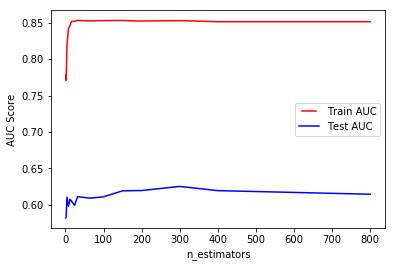

In [15]:
n_estimators = [1, 2, 4, 8, 12, 16, 24, 32, 64, 100, 150, 200, 300, 400, 800]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results,'r', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'b', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()

# n_estimators = 100

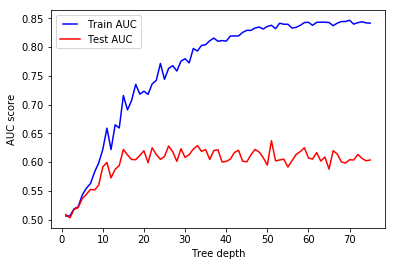

In [16]:
max_depths = np.linspace(1, 75, 75, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
# max depth = 30

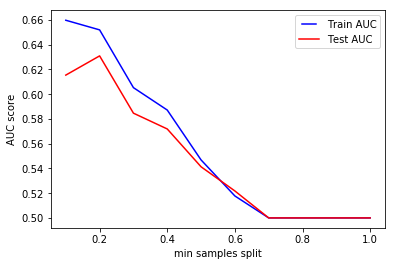

In [17]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

# min sample split = 0

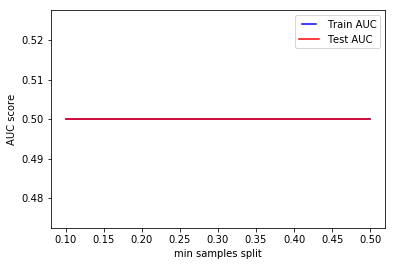

In [18]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()
# irrelevant

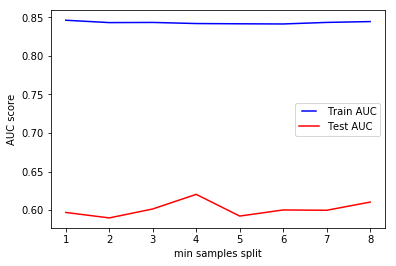

In [19]:
max_features = list(range(1,traindf.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()
# also irrelevant